In [3]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [4]:
sigma = 0.1
a = 0.1
timestep = 360
length = 30 # in years
forward_rate = 0.05
todays_date = ql.Date(15, 1, 2015)
day_count = ql.Thirty365()

In [5]:
ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

In [6]:
hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

In [7]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

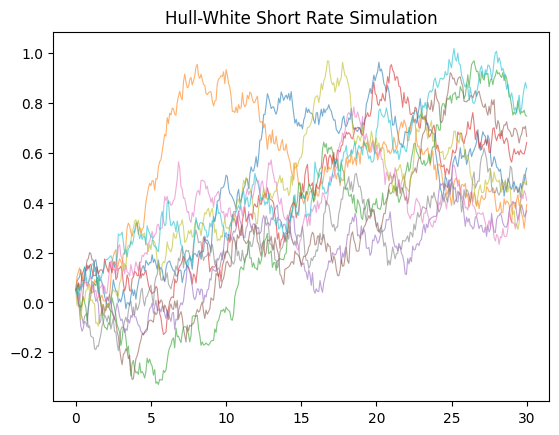

In [8]:
num_paths = 10
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

In [9]:
num_paths = 1000
time, paths = generate_paths(num_paths, timestep)

Text(0.5, 1.0, 'Variance of Short Rates')

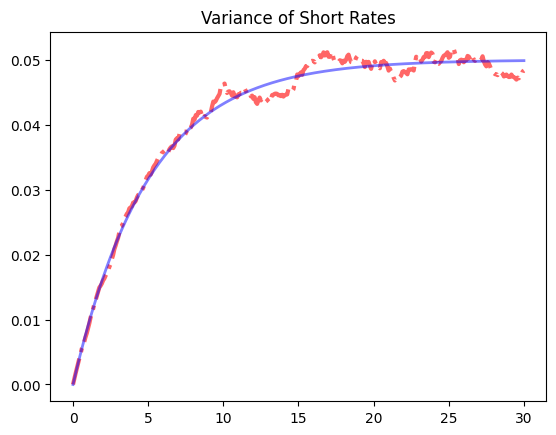

In [10]:
vol = [np.var(paths[:, i]) for i in range(timestep+1)]
plt.plot(time, vol, "r-.", lw=3, alpha=0.6)
plt.plot(time,sigma*sigma/(2*a)*(1.0-np.exp(-2.0*a*np.array(time))), "b-", lw=2, alpha=0.5)
plt.title("Variance of Short Rates")

Text(0.5, 1.0, 'Mean of Short Rates')

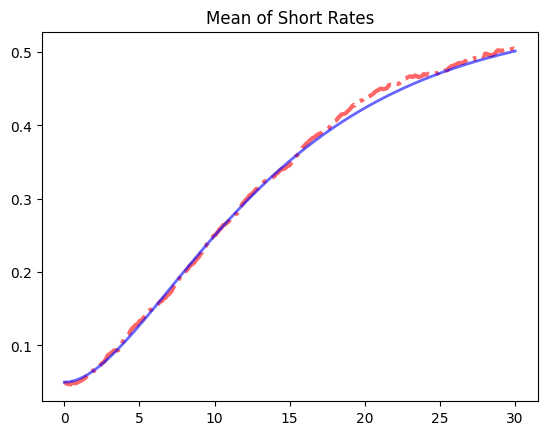

In [11]:
def alpha(forward, sigma, a, t):
    return forward + 0.5* np.power(sigma/a*(1.0 - np.exp(-a*t)), 2)

avg = [np.mean(paths[:, i]) for i in range(timestep+1)]
plt.plot(time, avg, "r-.", lw=3, alpha=0.6)
plt.plot(time,alpha(forward_rate, sigma, a, time), "b-", lw=2, alpha=0.6)
plt.title("Mean of Short Rates")

<Figure size 640x480 with 0 Axes>

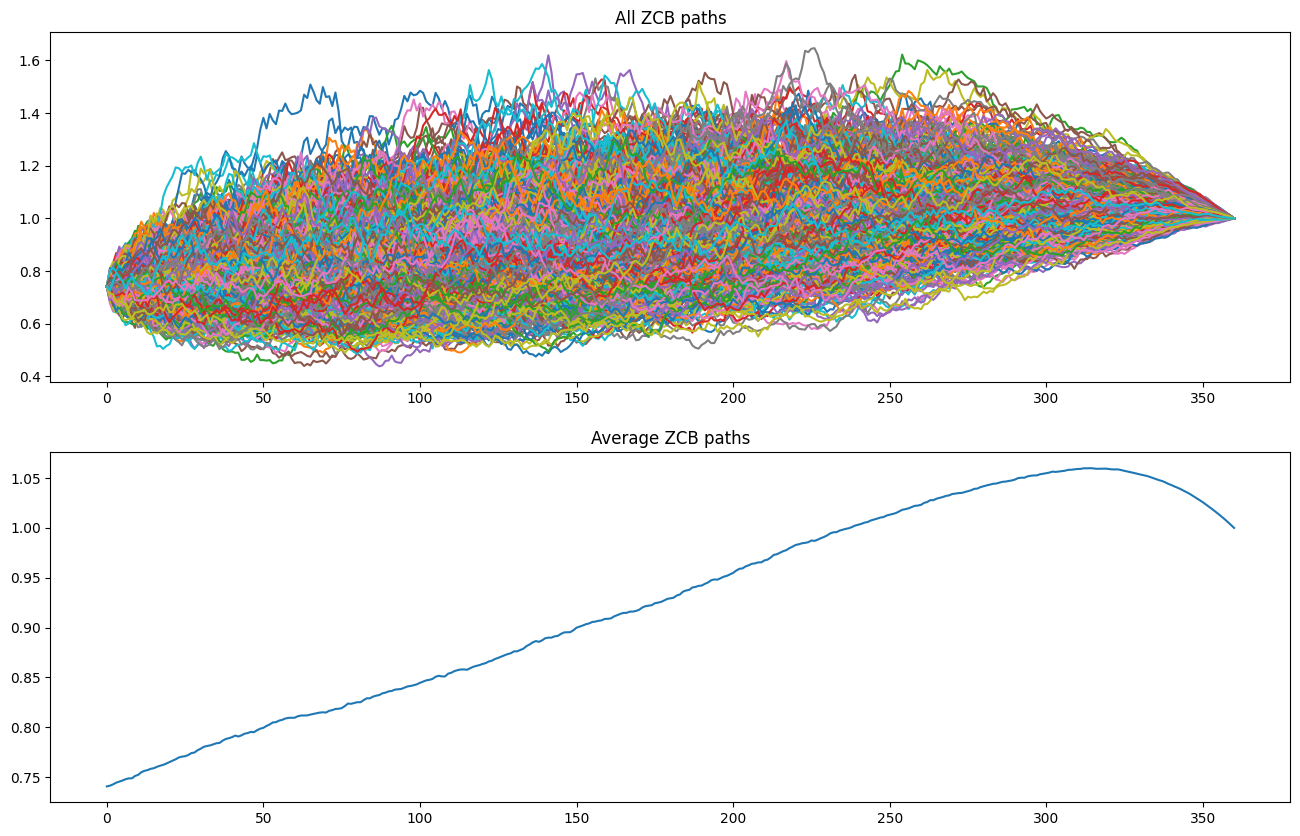

In [12]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


sigma = 0.01
a = 0.1
length = 30 # in years
steps_per_year = 12
timestep = length * steps_per_year
forward_rate = 0.01
day_count = ql.Thirty360(ql.Thirty360.BondBasis)
todays_date = ql.Date(15, 1, 2015)


ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)


def generate_paths(n_scenarios):
    arr = np.zeros((n_scenarios, timestep+1))
    for i in range(n_scenarios):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

n_scenarios = 1000
time, paths = generate_paths(n_scenarios)
rates = pd.DataFrame(paths).T

#price a zero coupon bond
n_years = length
num_steps = timestep
dt = 1 / steps_per_year
prices = np.empty_like(rates)


def price(T, t, f0, rt):
    tau = T - t
    B = (1 - np.exp(-a * tau)) / a
    A = np.exp(-f0 * tau + B * f0 - sigma ** 2 / (4 * a ** 3) *
               (np.exp(-a * T) - np.exp(-a * t)) * (np.exp(2 * a * t) - 1))
    return A * np.exp(-rt * B)

prices[0] = price(n_years,dt*0, forward_rate, rates.values[0])

for steps in range(1,num_steps+1):
    prices[steps] = price(n_years, dt * steps, forward_rate, rates.values[steps])


fig = plt.figure()
plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
plt.title("All ZCB paths")
plt.plot(prices)

plt.subplot(2, 1, 2)

ave = [np.mean(x) for x in prices]
plt.plot(ave)
plt.title("Average ZCB paths")

plt.show()